In [36]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import time
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier

In [37]:
from urllib.request import urlretrieve
import os

if not os.path.exists('secom.data'):
    print("Downloading SECOM dataset...")
    urlretrieve('https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data', 'secom.data')
    urlretrieve('https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data', 'secom_labels.data')

data = pd.read_csv('secom.data', sep='\s+', header=None)
labels = pd.read_csv('secom_labels.data', sep='\s+', header=None)

print(f"Data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")

constant_mask = data.nunique() == 1
constant_cols = data.columns[constant_mask]
print(f"Constant columns to remove: {len(constant_cols)}")

if len(constant_cols) > 0:
    data = data.drop(columns=constant_cols)

print(f"Shape after removal: {data.shape}")

print(f"NaN values before imputation: {data.isna().sum().sum()}")
data = data.apply(lambda x: x.fillna(x.median()), axis=0)
print(f"NaN values after imputation: {data.isna().sum().sum()}")

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)

print(f"Final data shape: {data_scaled.shape}")
print(f"Data range - Min: {data_scaled.min().min():.4f}, Max: {data_scaled.max().max():.4f}")

Data shape: (1567, 590)
Labels shape: (1567, 2)
Constant columns to remove: 116
Shape after removal: (1567, 474)
NaN values before imputation: 41136
NaN values after imputation: 0
Final data shape: (1567, 474)
Data range - Min: -37.9235, Max: 39.5727


In [39]:
X = data_scaled
y = labels.iloc[:, 0]

start_time = time.time()

mi_scores = mutual_info_classif(X, y, random_state=42)
top_20_mi_idx = np.argsort(mi_scores)[-20:][::-1]
top_20_mi_features = X.columns[top_20_mi_idx].tolist()

mi_time = time.time() - start_time
print(f"Top 20 MI features selected in {mi_time:.2f} seconds")
print(f"MI scores range: {mi_scores.min():.4f} to {mi_scores.max():.4f}")

start_time = time.time()

estimator = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(estimator=estimator, n_features_to_select=20)
rfe.fit(X, y)

rfe_time = time.time() - start_time
top_20_rfe_features = X.columns[rfe.support_].tolist()

print(f"RFE completed in {rfe_time:.2f} seconds")
print(f"Selected {len(top_20_rfe_features)} features")

Top 20 MI features selected in 2.44 seconds
MI scores range: 0.0000 to 0.0281
RFE completed in 2433.30 seconds
Selected 20 features


In [17]:
# Stop current execution and run this instead with different configuration

start_time = time.time()

estimator = RandomForestClassifier(n_estimators=30, max_depth=5, random_state=42)
rfe = RFE(estimator=estimator, n_features_to_select=20, step=5)
rfe.fit(X, y)

rfe_time = time.time() - start_time
top_20_rfe_features = X.columns[rfe.support_].tolist()

print(f"Fast RFE completed in {rfe_time:.2f} seconds")
print(f"Selected {len(top_20_rfe_features)} features")

Fast RFE completed in 27.98 seconds
Selected 20 features


In [19]:
U, Sigma, Vt = np.linalg.svd(data_scaled, full_matrices=False)

In [22]:
def feature_scores_svd_normalized(Vt, Sigma, k=20):
    k = min(k, len(Sigma))
    Vt_k = Vt[:k, :]
    Sigma_k = Sigma[:k]
    
    Sigma_norm = Sigma_k / Sigma_k.sum()
    
    scores = np.sum((Sigma_norm[:, np.newaxis]) * np.abs(Vt_k), axis=0)
    
    return scores

svd_scores_norm = feature_scores_svd_normalized(Vt, Sigma, k=20)
top_20_svd_idx_norm = np.argsort(svd_scores_norm)[-20:][::-1]
top_20_svd_features_norm = data_scaled.columns[top_20_svd_idx_norm].tolist()

print(f"Normalized SVD scores range: {svd_scores_norm.min():.6f} to {svd_scores_norm.max():.6f}")
print(f"\nTop 5 features with normalized scores:")
for i in range(5):
    print(f"  Feature {top_20_svd_features_norm[i]}: {svd_scores_norm[top_20_svd_idx_norm[i]]:.6f}")

Normalized SVD scores range: 0.006444 to 0.052291

Top 5 features with normalized scores:
  Feature 303: 0.052291
  Feature 168: 0.051149
  Feature 556: 0.048934
  Feature 550: 0.048922
  Feature 132: 0.048786


Creating loading plot...


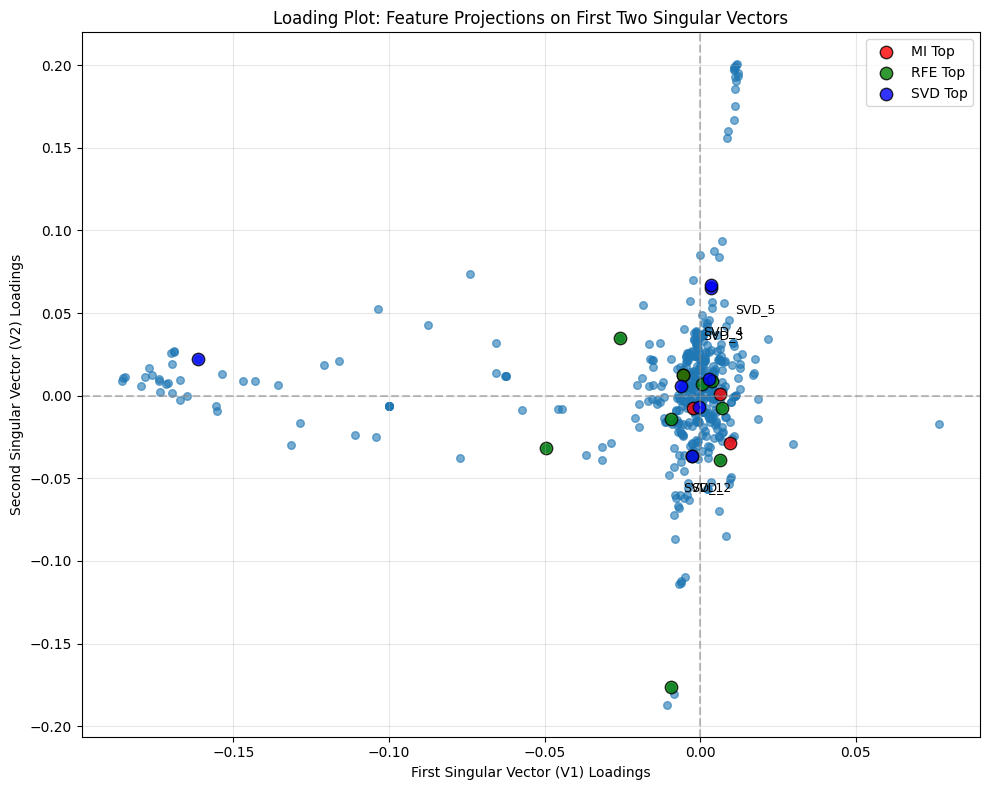

Loading plot created.
Total features plotted: 474
V1 range: [-0.186, 0.077]
V2 range: [-0.187, 0.201]


In [40]:
import matplotlib.pyplot as plt

print("Creating loading plot...")

V_component1 = Vt[0, :]
V_component2 = Vt[1, :]

plt.figure(figsize=(10, 8))
plt.scatter(V_component1, V_component2, alpha=0.6, s=30)

colors = ['red', 'green', 'blue']
methods = [top_20_mi_features, top_20_rfe_features, top_20_svd_features_norm]
labels = ['MI Top', 'RFE Top', 'SVD Top']

for color, method_features, label in zip(colors, methods, labels):
    feature_indices = []
    for f in method_features[:10]:
        try:
            idx = int(f)
            if idx < len(V_component1):
                feature_indices.append(idx)
        except:
            continue
    
    if feature_indices:
        plt.scatter(V_component1[feature_indices], V_component2[feature_indices], 
                   color=color, alpha=0.8, s=80, label=label, edgecolors='black')

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('First Singular Vector (V1) Loadings')
plt.ylabel('Second Singular Vector (V2) Loadings')
plt.title('Loading Plot: Feature Projections on First Two Singular Vectors')
plt.legend()
plt.grid(alpha=0.3)

for i in range(5):
    idx = top_20_svd_idx_norm[i]
    plt.annotate(f'SVD_{i+1}', (V_component1[idx], V_component2[idx]), 
                 xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.show()

print("Loading plot created.")
print(f"Total features plotted: {len(V_component1)}")
print(f"V1 range: [{V_component1.min():.3f}, {V_component1.max():.3f}]")
print(f"V2 range: [{V_component2.min():.3f}, {V_component2.max():.3f}]")

In [26]:
original_svd_features = set(top_20_svd_features_norm)
original_rfe_features = set(top_20_rfe_features)

print(f"Original SVD features: {sorted([int(f) for f in original_svd_features])}")
print(f"Original RFE features: {sorted([int(f) for f in original_rfe_features])}")

def test_stability(n_trials=5, noise_level=0.05):
    svd_stabilities = []
    rfe_stabilities = []
    
    for trial in range(n_trials):
        print(f"\n--- Trial {trial+1}/{n_trials} ---")
        
        np.random.seed(42 + trial)
        noise = np.random.normal(0, noise_level * np.std(data_scaled, axis=0), data_scaled.shape)
        X_noisy = data_scaled + noise
        
        U_n, Sigma_n, Vt_n = np.linalg.svd(X_noisy, full_matrices=False)
        svd_scores_n = feature_scores_svd_normalized(Vt_n, Sigma_n, k=20)
        top_svd_n_idx = np.argsort(svd_scores_n)[-20:][::-1]
        svd_features_n = set(data_scaled.columns[top_svd_n_idx].tolist())
        
        start_time = time.time()
        estimator = RandomForestClassifier(n_estimators=30, max_depth=5, random_state=42+trial)
        rfe_n = RFE(estimator=estimator, n_features_to_select=20, step=5)
        rfe_n.fit(X_noisy, y)
        rfe_features_n = set(data_scaled.columns[rfe_n.support_].tolist())
        
        svd_sim = len(original_svd_features & svd_features_n) / len(original_svd_features | svd_features_n)
        rfe_sim = len(original_rfe_features & rfe_features_n) / len(original_rfe_features | rfe_features_n)
        
        svd_stabilities.append(svd_sim)
        rfe_stabilities.append(rfe_sim)
        
        print(f"SVD similarity: {svd_sim:.3f}")
        print(f"RFE similarity: {rfe_sim:.3f}")
        print(f"RFE time: {time.time()-start_time:.1f}s")
    
    return svd_stabilities, rfe_stabilities

svd_stabilities, rfe_stabilities = test_stability(n_trials=3, noise_level=0.05)

print(f"SVD average stability: {np.mean(svd_stabilities):.3f} ± {np.std(svd_stabilities):.3f}")
print(f"RFE average stability: {np.mean(rfe_stabilities):.3f} ± {np.std(rfe_stabilities):.3f}")

Original SVD features: [46, 62, 132, 168, 248, 267, 268, 303, 312, 386, 405, 406, 520, 539, 550, 551, 553, 554, 556, 557]
Original RFE features: [59, 63, 64, 65, 103, 152, 153, 205, 267, 348, 405, 425, 426, 437, 441, 442, 477, 494, 510, 539]

--- Trial 1/3 ---
SVD similarity: 0.905
RFE similarity: 0.379
RFE time: 47.1s

--- Trial 2/3 ---
SVD similarity: 0.905
RFE similarity: 0.250
RFE time: 51.4s

--- Trial 3/3 ---
SVD similarity: 0.818
RFE similarity: 0.290
RFE time: 43.9s
SVD average stability: 0.876 ± 0.041
RFE average stability: 0.307 ± 0.054


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, classification_report
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

print(y.value_counts())
print(f"Baseline (all negative): {y.value_counts().iloc[0]/len(y):.4f}")

X_full = data_scaled.values
y_labels = y.values

def get_valid_features(feature_list):
    valid_idx = []
    for f in feature_list:
        try:
            idx = int(f)
            if idx < X_full.shape[1]:
                valid_idx.append(idx)
        except:
            continue
    return valid_idx

mi_idx = get_valid_features(top_20_mi_features)
rfe_idx = get_valid_features(top_20_rfe_features)
svd_idx = get_valid_features(top_20_svd_features_norm)

X_mi = X_full[:, mi_idx[:20]] if len(mi_idx) >= 20 else X_full[:, mi_idx]
X_rfe = X_full[:, rfe_idx[:20]] if len(rfe_idx) >= 20 else X_full[:, rfe_idx]
X_svd = X_full[:, svd_idx[:20]] if len(svd_idx) >= 20 else X_full[:, svd_idx]

X_train_mi, X_test_mi, y_train, y_test = train_test_split(X_mi, y_labels, test_size=0.3, random_state=42, stratify=y_labels)
X_train_rfe, X_test_rfe, _, _ = train_test_split(X_rfe, y_labels, test_size=0.3, random_state=42, stratify=y_labels)
X_train_svd, X_test_svd, _, _ = train_test_split(X_svd, y_labels, test_size=0.3, random_state=42, stratify=y_labels)

0
-1    1463
 1     104
Name: count, dtype: int64
Baseline (all negative): 0.9336


In [31]:
model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

start = time.time()
model.fit(X_train_mi, y_train)
y_pred_mi = model.predict(X_test_mi)
train_time_mi = time.time() - start

start = time.time()
model.fit(X_train_rfe, y_train)
y_pred_rfe = model.predict(X_test_rfe)
train_time_rfe = time.time() - start

start = time.time()
model.fit(X_train_svd, y_train)
y_pred_svd = model.predict(X_test_svd)
train_time_svd = time.time() - start

def calculate_all_metrics(y_true, y_pred, method_name):
    return {
        'method': method_name,
        'accuracy': accuracy_score(y_true, y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'train_time': train_time_mi if 'MI' in method_name else train_time_rfe if 'RFE' in method_name else train_time_svd
    }

metrics_mi = calculate_all_metrics(y_test, y_pred_mi, "MI")
metrics_rfe = calculate_all_metrics(y_test, y_pred_rfe, "RFE")
metrics_svd = calculate_all_metrics(y_test, y_pred_svd, "SVD")

Method     Accuracy   Balanced Acc F1-Score   Train Time
------------------------------------------------------------
MI         0.5754     0.5029       0.1150     0.017     
RFE        0.6518     0.5288       0.1277     0.004     
SVD        0.5754     0.5778       0.1525     0.008     


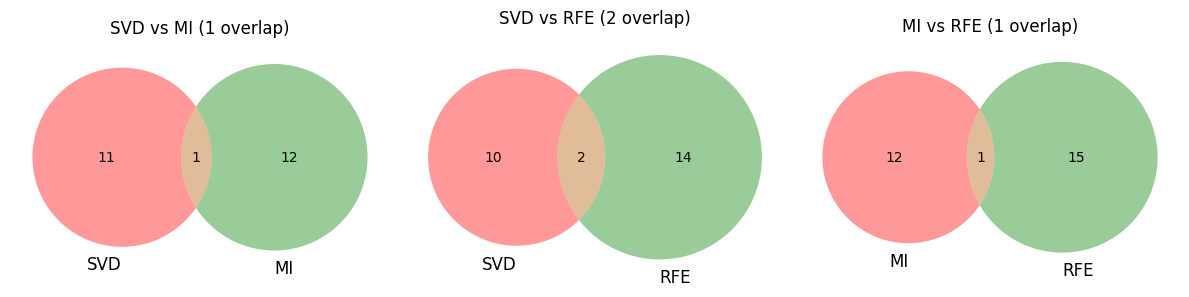

In [33]:
print(f"{'Method':<10} {'Accuracy':<10} {'Balanced Acc':<12} {'F1-Score':<10} {'Train Time':<10}")
print("-" * 60)
for metrics in [metrics_mi, metrics_rfe, metrics_svd]:
    print(f"{metrics['method']:<10} {metrics['accuracy']:<10.4f} {metrics['balanced_accuracy']:<12.4f} "
          f"{metrics['f1']:<10.4f} {metrics['train_time']:<10.3f}")

plt.figure(figsize=(12, 4))

svd_set = set([int(f) for f in top_20_svd_features_norm if int(f) < X_full.shape[1]])
mi_set = set([int(f) for f in top_20_mi_features if int(f) < X_full.shape[1]])
rfe_set = set([int(f) for f in top_20_rfe_features if int(f) < X_full.shape[1]])

plt.subplot(1, 3, 1)
venn2([svd_set, mi_set], set_labels=('SVD', 'MI'))
plt.title(f'SVD vs MI ({len(svd_set & mi_set)} overlap)')

plt.subplot(1, 3, 2)
venn2([svd_set, rfe_set], set_labels=('SVD', 'RFE'))
plt.title(f'SVD vs RFE ({len(svd_set & rfe_set)} overlap)')

plt.subplot(1, 3, 3)
venn2([mi_set, rfe_set], set_labels=('MI', 'RFE'))
plt.title(f'MI vs RFE ({len(mi_set & rfe_set)} overlap)')

plt.tight_layout()
plt.show()